In [1]:
!pip install stable-baselines3==2.1.0
!pip install gymnasium==0.29.1
!pip install shimmy==1.2.1
!pip install yfinance
!pip install ta
!pip install pandas numpy scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [2]:
import yfinance as yf

data = yf.download("SPY", start="2010-01-01", end="2024-01-01")
print(data.head())
data.to_csv("spy_data.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker            SPY        SPY        SPY        SPY        SPY
Date                                                             
2010-01-04  85.768440  85.813847  84.391060  85.041910  118944600
2010-01-05  85.995461  86.033303  85.405156  85.715447  111579900
2010-01-06  86.056038  86.267942  85.844134  85.912244  116074400
2010-01-07  86.419312  86.525263  85.654939  85.897116  131091100
2010-01-08  86.706886  86.744729  86.018199  86.192260  126402800


In [3]:
import pandas as pd
from sklearn.mixture import GaussianMixture

df = pd.read_csv("spy_data.csv", index_col=0)
print(df.head())

df.index = pd.to_datetime(df.index, errors='coerce')
df = df.dropna()

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

df["returns"] = df["Close"].pct_change()
df["volatility"] = df["returns"].rolling(window=10).std()

df = df.dropna()

X = df[["returns", "volatility"]]
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

df["regime"] = gmm.predict(X)

print(df.head())

df.to_csv("spy_regime_data.csv")

                        Close               High                Low  \
Price                                                                 
Ticker                    SPY                SPY                SPY   
Date                      NaN                NaN                NaN   
2010-01-04  85.76844024658203  85.81384655502683  84.39105974228248   
2010-01-05   85.9954605102539  86.03330294241766   85.4051555217439   
2010-01-06  86.05603790283203   86.2679417438128  85.84413406185128   

                         Open     Volume  
Price                                     
Ticker                    SPY        SPY  
Date                      NaN        NaN  
2010-01-04  85.04191044173733  118944600  
2010-01-05   85.7154472984422  111579900  
2010-01-06   85.9122435361894  116074400  
                Close               High                Low  \
Price                                                         
2010-01-19  87.077713  87.13068896842462   85.9652121684335   
2010-01-20  

<ipython-input-3-59b46af027c3>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')


In [4]:
!pip install gym
!pip install stable-baselines3
!pip install gymnasium

In [7]:
import gym
from gym import spaces
import numpy as np

class TradingEnvironment(gym.Env):
    def __init__(self, df):
        super(TradingEnvironment, self).__init__()

        self.df = df
        self.max_steps = len(df) - 1
        self.current_step = 0

        self.action_space = spaces.Discrete(3)

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)

        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_shares = 0
        self.buy_price = 0
        self.done = False

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_shares = 0
        self.buy_price = 0
        self.done = False
        return self._get_observation()

    def step(self, action):
        if self.done:
            return self._get_observation(), 0, True, {}

        current_price = self.df.iloc[self.current_step]["Close"]
        prev_price = self.df.iloc[self.current_step - 1]["Close"] if self.current_step > 0 else current_price

        if action == 0:
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
                self.buy_price = current_price
        elif action == 1:
            pass
        elif action == 2:
            if self.shares_held > 0:
                self.balance += current_price
                self.shares_held -= 1

        self.current_step += 1

        if self.current_step >= self.max_steps:
            self.done = True

        return self._get_observation(), self.balance + self.shares_held * current_price, self.done, {}

    def _get_observation(self):
        current_price = self.df.iloc[self.current_step]["Close"]
        prev_price = self.df.iloc[self.current_step - 1]["Close"] if self.current_step > 0 else current_price
        return np.array([current_price, prev_price, self.balance, self.shares_held], dtype=np.float32)

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}, Shares Held: {self.shares_held}")

In [9]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO # Import PPO

env = DummyVecEnv([lambda: TradingEnvironment(df)])

model = PPO("MlpPolicy", env, verbose=1)

model.learn(total_timesteps=50000)

model.save("ppo_trading_model")

test_env = TradingEnvironment(df)
test_obs = test_env.reset()

for i in range(100):
    action, _states = model.predict(test_obs)
    test_obs, reward, done, info = test_env.step(action)
    test_env.render()
    if done:
        break

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 895  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 727           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 5.6151446e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 2.527237e-05  |
|    learning_rate        | 0.0003        |
|    loss                 | 3e+08         |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000291     |
|    value_loss           | 5.71e+08      |
-------------------------

In [10]:
obs = env.reset()

total_rewards = 0
for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    total_rewards += rewards
    if done:
        obs = env.reset()

print("Total rewards:", total_rewards)

Total rewards: [1265135.]


In [11]:
model.save("trained_trading_model")

In [12]:
loaded_model = PPO.load("trained_trading_model")

obs = env.reset()

total_rewards = 0
for _ in range(1000):
    action, _states = loaded_model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    total_rewards += rewards
    if done:
        obs = env.reset()

print("Total rewards after reloading:", total_rewards)

Total rewards after reloading: [1265135.]


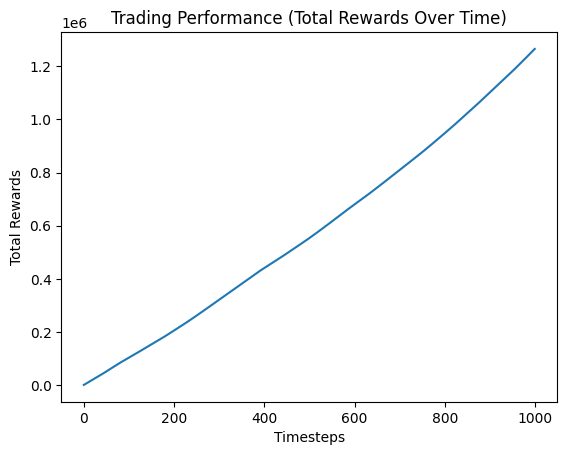

In [13]:
import matplotlib.pyplot as plt

obs = env.reset()
total_rewards = []
all_rewards = []

for _ in range(1000):
    action, _states = loaded_model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    all_rewards.append(rewards)
    total_rewards.append(sum(all_rewards))

    if done:
        obs = env.reset()

plt.plot(total_rewards)
plt.title('Trading Performance (Total Rewards Over Time)')
plt.xlabel('Timesteps')
plt.ylabel('Total Rewards')
plt.show()

In [14]:
!pip install flask

In [15]:
dates = pd.date_range(start="2020-01-01", end="2022-01-01", freq="B")
prices = np.random.randn(len(dates)) * 0.01 + 0.001

test_data = pd.DataFrame(prices, index=dates, columns=["Price"])
test_data["Price"] = test_data["Price"].cumsum() + 100
test_data.to_csv("test_data.csv")

In [16]:
test_data = pd.read_csv("test_data.csv", index_col=0)
test_data.index = pd.to_datetime(test_data.index)

In [22]:
predicted_returns = np.random.randn(len(test_data)) * 0.01 + 0.001

mean_return = np.mean(predicted_returns)
std_return = np.std(predicted_returns)

sharpe_ratio = mean_return / std_return * np.sqrt(252)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 1.89


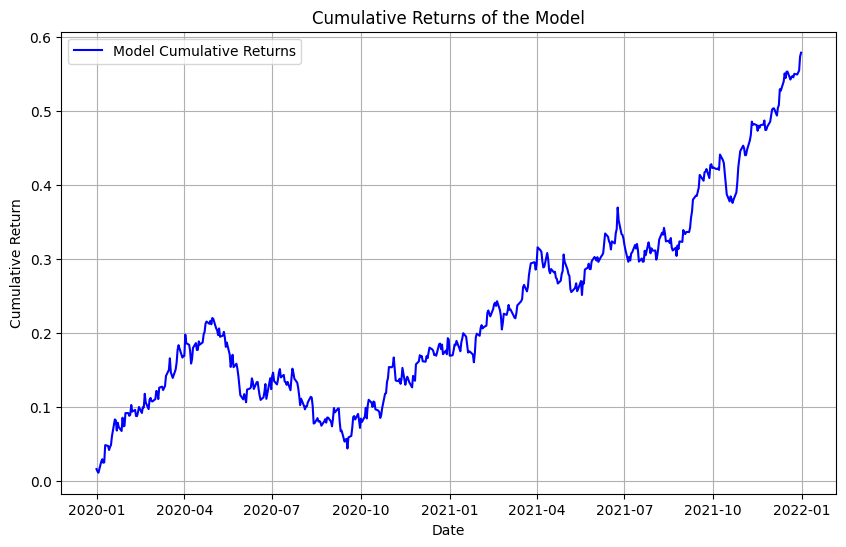

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cumulative_returns = np.cumsum(predicted_returns)

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, cumulative_returns, label="Model Cumulative Returns", color='blue')
plt.title("Cumulative Returns of the Model")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

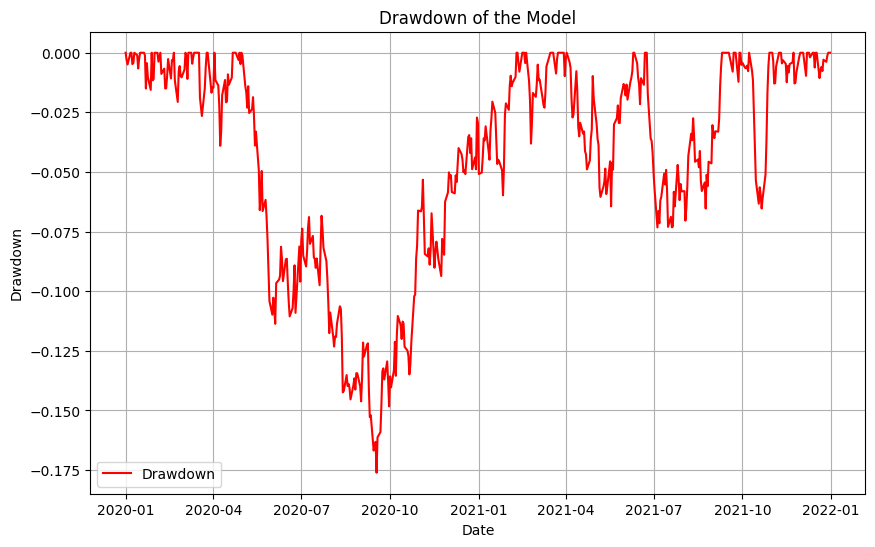

In [24]:
peak = np.maximum.accumulate(cumulative_returns)
drawdown = cumulative_returns - peak

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, drawdown, label="Drawdown", color='red')
plt.title("Drawdown of the Model")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()

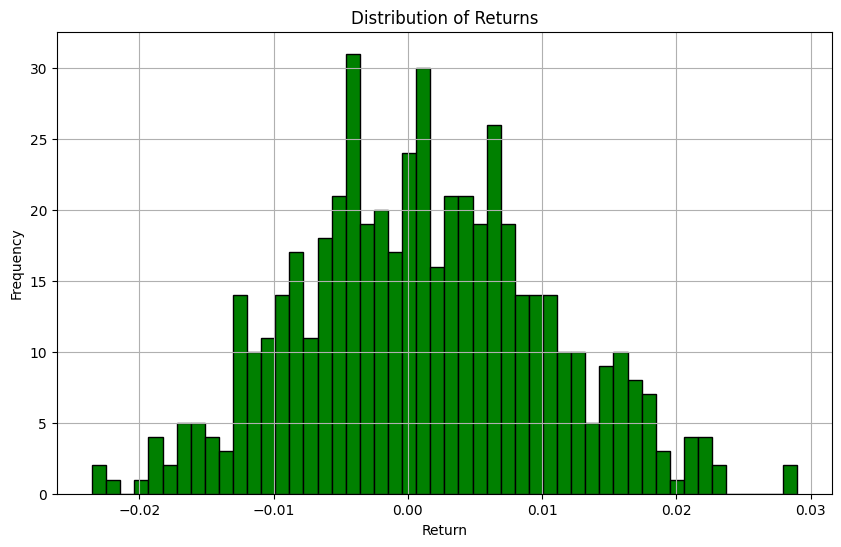

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(predicted_returns, bins=50, color='green', edgecolor='black')
plt.title("Distribution of Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

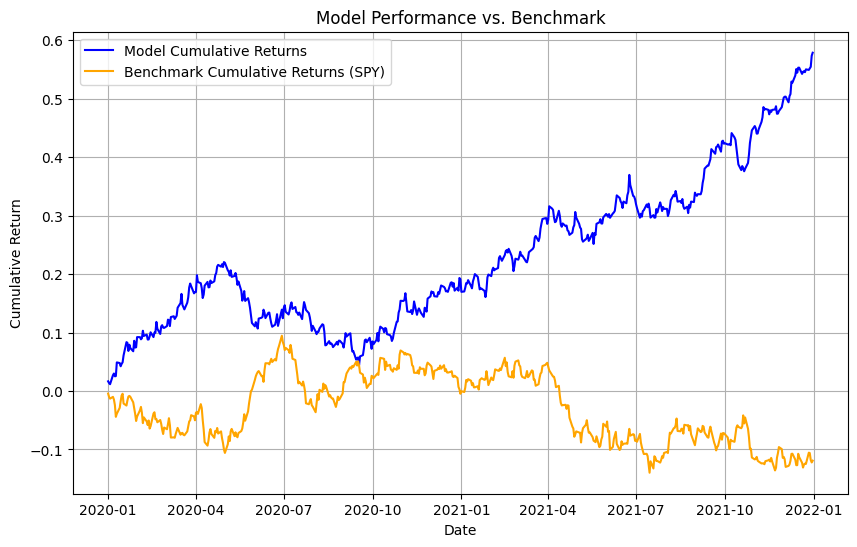

In [27]:
benchmark_returns = np.random.randn(len(test_data)) * 0.01

benchmark_cumulative_returns = np.cumsum(benchmark_returns)

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, cumulative_returns, label="Model Cumulative Returns", color='blue')
plt.plot(test_data.index, benchmark_cumulative_returns, label="Benchmark Cumulative Returns (SPY)", color='orange')
plt.title("Model Performance vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
max_drawdown = np.min(drawdown)

volatility = np.std(predicted_returns) * np.sqrt(252)

cagr = (cumulative_returns[-1] / cumulative_returns[0]) ** (1 / (len(test_data) / 252)) - 1

print(f"Max Drawdown: {max_drawdown:.2f}")
print(f"Volatility: {volatility:.2f}")
print(f"CAGR: {cagr:.2f}")

Max Drawdown: -0.18
Volatility: 0.15
CAGR: 4.53


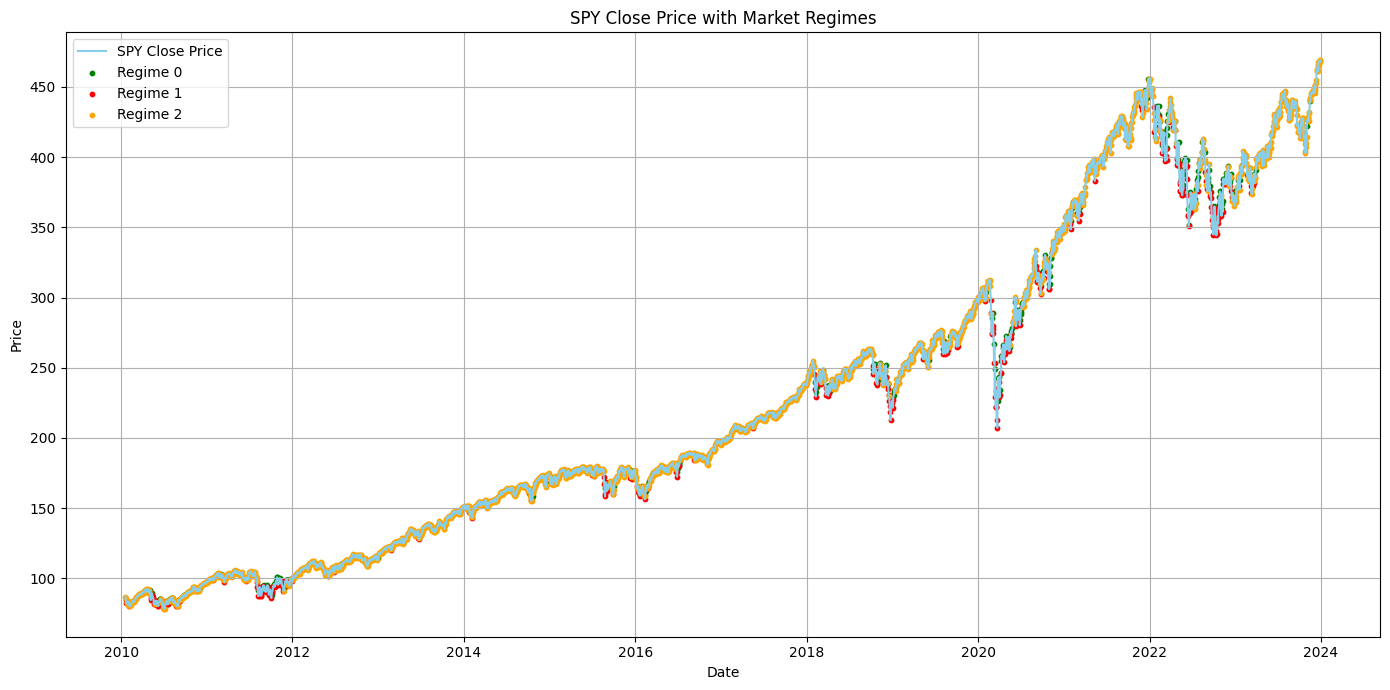

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='SPY Close Price', color='skyblue')
colors = {0: 'green', 1: 'red', 2: 'orange'}
for regime, color in colors.items():
    plt.scatter(df[df['regime'] == regime].index,
                df['Close'][df['regime'] == regime],
                color=color, label=f'Regime {regime}', s=10)
plt.title('SPY Close Price with Market Regimes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

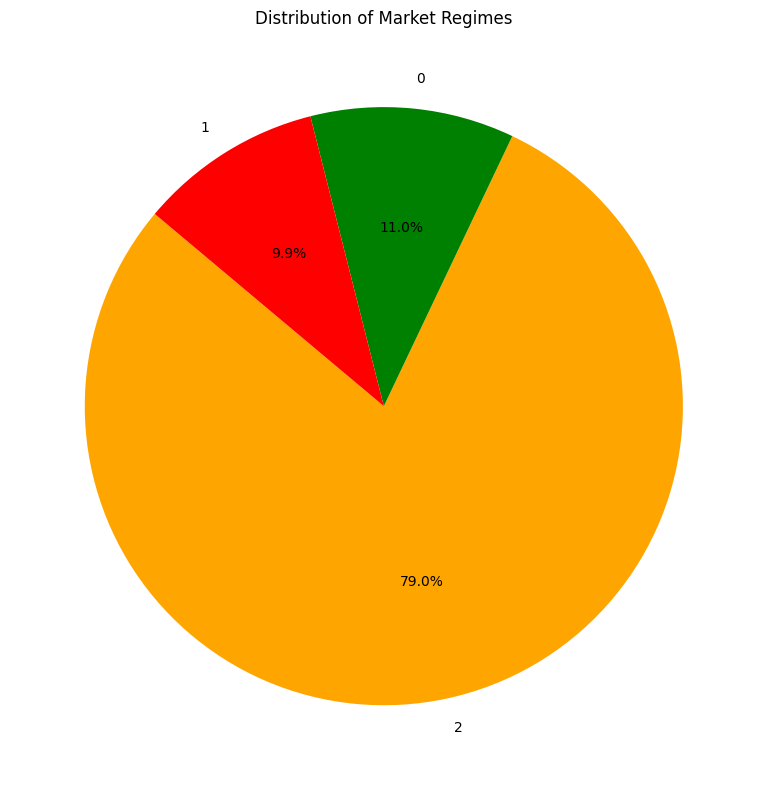

In [34]:
regime_counts = df['regime'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(regime_counts, labels=regime_counts.index, autopct='%1.1f%%',
        colors=[colors[i] for i in regime_counts.index], startangle=140)
plt.title('Distribution of Market Regimes')
plt.tight_layout()
plt.show()